In [2]:
import numpy as np

def createImage(rows, cols, edge):
    clean = np.zeros((rows, cols))
    
    for i in range(cols):
        clean[:, i] = i / (cols - 1)

    for i in range(edge, cols - edge):
        clean[edge:rows - edge, i] = 1 - ((i - edge) / (cols - edge * 2 - 1))

    noisy = clean + np.random.normal(0, 0.05, size=(rows, cols))
    return clean, noisy

size = 32
edge = size // 4

clean, noisy = createImage(size, size, edge)


In [9]:
import numpy as np
import math

class TGV:
    iter_num = 150

    tau = 1 / 64
    alpha0 = 0.1
    alpha1 = 0.05
    sigma = 0.125
    errors = []

    def __init__(self, input, clean):
        self.input = input
        self.clean = clean
        self.rows = input.shape[0]
        self.cols = input.shape[1]

        self.v0 = np.zeros((self.rows, self.cols, 3))
        self.v1 = np.zeros((self.rows, self.cols, 3))
        self.v_bar = np.zeros((self.rows, self.cols, 3))
        self.v_hat = np.zeros((self.rows, self.cols, 3))

        self.eta0 = np.zeros((self.rows, self.cols, 2))
        self.eta1 = np.zeros((self.rows, self.cols, 2))
        self.eta_bar = np.zeros((self.rows, self.cols, 2))

        
    def square_sym_grad(self, src):
        src_zero = np.zeros((self.rows + 2, self.cols + 2))
        src_zero[1:-1, 1:-1] = src

        src_edge = np.zeros((src.shape[0] + 2, src.shape[1] + 2))
        src_edge[1:-1, 1:-1] = src
        src_edge[1:-1, 0] = src[:, 0]
        src_edge[1:-1, -1] = src[:, -1]
        src_edge[0, 1:-1] = src[0, :]
        src_edge[-1, 1:-1] = src[-1, :]

        dst = np.zeros((self.rows, self.cols, 3))

        for y in range(0, self.rows):
            for x in range(0, self.cols):
                dst[y, x, 0] = np.sum(np.array(([1, -2, 1])) * src_edge[y + 1, x:x + 3])
                dst[y, x, 1] = np.sum(np.array(([1, -2, 1])) * src_edge[y:y+3, x + 1])
                dst[y, x, 2] = (np.sum(np.array(([[0, 1, -1], [1, -2, 1], [-1, 1, 0]])) * src_zero[y:y + 3, x:x + 3])) * 0.5
        return dst


    def square_div(self, src):
        src0 = np.zeros((self.rows + 2, self.cols + 2))
        src1 = np.zeros((self.rows + 2, self.cols + 2))
        src2 = np.zeros((self.rows + 2, self.cols + 2))

        src0[1:-1, 1:-1] = src[:, :, 0]
        src1[1:-1, 1:-1] = src[:, :, 1]
        src2[1:-1, 1:-1] = src[:, :, 2]

        src0[1:-1, 0] = src[:, 0, 0]
        src0[1:-1, -1] = src[:, -1, 0]
        src0[0, 1:-1] = src[0, :, 0]
        src0[-1, 1:-1] = src[-1, :, 0]

        src1[1:-1, 0] = src[:, 0, 1]
        src1[1:-1, -1] = src[:, -1, 1]
        src1[0, 1:-1] = src[0, :, 1]
        src1[-1, 1:-1] = src[-1, :, 1]

        dst = np.zeros((self.rows, self.cols))

        for y in range(0, self.rows):
            for x in range(0, self.cols):
                dst[y, x] = np.sum(np.array(([1, -2, 1])) * src0[y + 1, x:x + 3]) \
                    + np.sum(np.array(([1, -2, 1])) * src1[y:y+3, x + 1]) \
                    + np.sum(np.array(([[0, 1, -1], [1, -2, 1], [-1, 1, 0]])) * src2[y:y + 3, x:x + 3])
        return dst

    
    def sym_grad(self, src):
        dst = np.zeros((self.rows, self.cols, 3))

        dst[:, 1:, 0] = src[:, 1:, 0] - src[:, :-1, 0]
        dst[:, 0, 0] = src[:, 0, 0]
        dst[:, -1, 0] = -src[:, -2, 0]

        dst[1:, :, 1] = src[1:, :, 1] - src[:-1, :, 1]
        dst[0, :, 1] = src[0, :, 1]
        dst[-1, :, 1] = -src[-2, :, 1]

        tmp = np.zeros((self.rows, self.cols, 2))
        tmp[:, 1:, 0] = src[:, 1:, 1] - src[:, :-1, 1]
        tmp[:, 0, 0] = src[:, 0, 1]
        tmp[:, -1, 0] = -src[:, -2, 1]

        tmp[1:, :, 1] = src[1:, :, 0] - src[:-1, :, 0]
        tmp[0, :, 1] = src[0, :, 0]
        tmp[-1, :, 1] = -src[-2, :, 0]
        dst[:, :, 2] = (tmp[:, :, 0] + tmp[:, :, 1]) * 0.5

        return dst

    
    def divergence(self, src):
        dst = np.zeros((self.rows, self.cols, 2))

        tmp = np.zeros((self.rows, self.cols, 4))
        tmp[:, :-1, 0] = src[:, 1:, 0] - src[:, :-1, 0]
        tmp[:-1, :, 1] = src[1:, :, 1] - src[:-1, :, 1]
        tmp[:-1, :, 2] = src[1:, :, 2] - src[:-1, :, 2]
        tmp[:, :-1, 3] = src[:, 1:, 2] - src[:, :-1, 2]

        dst[:, :, 0] = tmp[:, :, 0] + tmp[:, :, 2]
        dst[:, :, 1] = tmp[:, :, 1] + tmp[:, :, 3]

        return dst

    
    def update_nesterov_param(self, t):
        return (1 + math.sqrt(1 + 4 * t * t)) / 2

    
    def shrink(self, image, lamb):
        abs_img = np.abs(image)
        shrink_img = np.where((abs_img - lamb) > 0,  (abs_img - lamb) * image / abs_img, 0)
        return shrink_img

    def calc_error(self):
        sub = self.v_hat - self.v1
        return np.sum(np.square(sub[:, :, 0]) + np.square(sub[:, :, 1]) + 2 * np.square(sub[:, :, 2]))

    def prox_grad(self):
        t0 = 1
        t1 = self.update_nesterov_param(t0)
        t2 = self.update_nesterov_param(t1)

        for i in range(self.iter_num):
            tmp = self.v_hat + self.sym_grad(self.eta_bar)
            q = self.shrink(tmp, self.alpha0)

            self.eta1 = self.shrink(self.eta_bar + self.sigma * self.divergence(tmp - q), self.sigma * self.alpha1)
            self.eta_bar = self.eta1 + t0 / t2 * (self.eta1 - self.eta0)

            tmp_error = self.calc_error()
            if tmp_error < 1.0e-4:
                break
                
            self.eta0 = self.eta1
            t0 = t1
            t1 = t2
            t2 = self.update_nesterov_param(t2)

        # print(np.sqrt(np.sum(np.square(self.v_hat - q + self.sym_grad(self.eta1)))))
        self.v1 =  self.v_hat - q + self.sym_grad(self.eta1)


    def denoise(self):
        t0 = 1
        t1 = self.update_nesterov_param(t0)
        t2 = self.update_nesterov_param(t1)

        for i in range(self.iter_num): # 
        # for i in range(1):
            # print(self.input)
            self.v_hat = self.v_bar + self.tau * self.square_sym_grad(self.input - self.square_div(self.v_bar))

            self.prox_grad()

            self.v_bar = self.v1 + t0 / t2 * (self.v1 - self.v0)
            
            t0 = t1
            t1 = t2
            t2 = self.update_nesterov_param(t2)
            self.v0 = self.v1

            error = np.sum(np.abs((self.input - self.square_div(self.v1)) - self.clean))
            #print(error)
            self.errors += [error]
            #print(np.sum(np.abs(square_div(v1))) / (rows * cols))

        # calc_u
        denoise = self.input - self.square_div(self.v1)

        return denoise

inp = np.array((
    [ [  0.134406,],  [  0.324319,],  [  0.463316,],  [  0.50489,],  [  0.590114,],  [  0.700973,],  [  0.749472,],  [  1,], ],
    [ [  0.132836,],  [  0.324319,],  [  0.269897,],  [  0.550089,],  [  0.599105,],  [  0.740044,],  [  0.858524,],  [  0.923825,], ],
    [ [  0.280201,],  [  0.279064,],  [  0.402278,],  [  0.559652,],  [  0.501103,],  [  0.752126,],  [  0.816824,],  [  0.862465,], ],
    [ [  0.256639,],  [  0.361794,],  [  0.414381,],  [  0.734061,],  [  0.626987,],  [  0.399523,],  [  0.737526,],  [  0.871982,], ],
    [ [  0.0423307,],  [  0.312881,],  [  0.34472,],  [  0.811435,],  [  0.588207,],  [  0.389988,],  [  0.87638,],  [  0.915455,], ],
    [ [  0.179548,],  [  0.287256,],  [  0.312178,],  [  0.711284,],  [  0.576404,],  [  0.407887,],  [  0.791423,],  [  0.914356,], ],
    [ [  0.160355,],  [  0.289988,],  [  0.51374,],  [  0.56378,],  [  0.666209,],  [  0.733925,],  [  0.774516,],  [  0.922785,], ],
    [ [  0.197286,],  [  0.225062,],  [  0.432054,],  [  0.508955,],  [  0.503164,],  [  0.693805,],  [  0.771629,],  [  0.864843,], ],
))

inp = inp[:, :, 0]

tgv = TGV(noisy, clean)
denoise = tgv.denoise()
# print(denoise)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


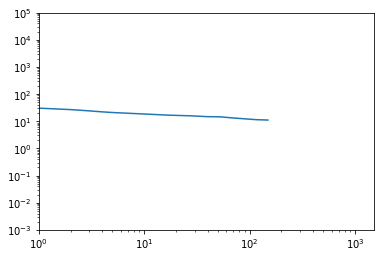

In [12]:
%matplotlib inline
import seaborn as sns

fig = sns.mpl.pyplot.figure()

ax = fig.add_subplot(111)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1.0e-3, 1.0e5)
ax.set_xlim(1, 1.5e3)

ax.plot(tgv.errors)

#print(tgv.errors)


In [ ]:
answer = np.array((
 [ [  0.150462,],  [  0.312217,],  [  0.424394,],  [  0.521212,],  [  0.595048,],  [  0.69671,],  [  0.815794,],  [  0.921057,], ],
 [ [  0.173424,],  [  0.268408,],  [  0.363754,],  [  0.504265,],  [  0.604706,],  [  0.739049,],  [  0.814754,],  [  0.940571,], ],
 [ [  0.25173,],  [  0.307781,],  [  0.391964,],  [  0.551941,],  [  0.571873,],  [  0.673045,],  [  0.812443,],  [  0.881388,], ],
 [ [  0.233246,],  [  0.332698,],  [  0.452298,],  [  0.678766,],  [  0.573308,],  [  0.512674,],  [  0.749627,],  [  0.863739,], ],
 [ [  0.123435,],  [  0.266485,],  [  0.420894,],  [  0.70839,],  [  0.594375,],  [  0.466657,],  [  0.775559,],  [  0.920428,], ],
 [ [  0.150775,],  [  0.269566,],  [  0.401005,],  [  0.638939,],  [  0.600958,],  [  0.513757,],  [  0.756748,],  [  0.925662,], ],
 [ [  0.179998,],  [  0.288844,],  [  0.45099,],  [  0.583735,],  [  0.632841,],  [  0.677084,],  [  0.789116,],  [  0.902903,], ],
 [ [  0.177035,],  [  0.256144,],  [  0.427608,],  [  0.501736,],  [  0.549822,],  [  0.687022,],  [  0.782046,],  [  0.866002,], ],
))

answer = answer[:, :, 0]

print(np.abs(answer - denoise) < 1e-3)


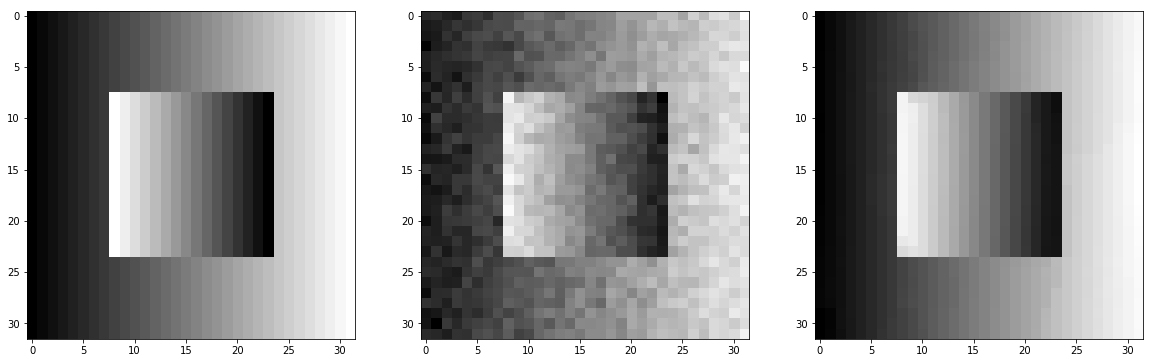

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig = sns.mpl.pyplot.figure(figsize=(20, 20))

ax = fig.add_subplot(131)
ax.imshow(clean, cmap='gray')

ax = fig.add_subplot(132)
ax.imshow(noisy, cmap='gray')

ax = fig.add_subplot(133)
ax.imshow(denoise, cmap='gray')

fig.savefig("test.png")
